In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile
from scipy.fftpack import dct
import numpy as np

from tempfile import TemporaryFile
import os
import pickle
import random 
import operator

import math
import numpy

import glob

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range (len(trainingSet)):
        dist = distance(trainingSet[x], instance, k )+ distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [3]:
def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response]+=1 
        else:
            classVote[response]=1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [4]:
#pre-emphasis
def pre_emphasis(signal):
    pre_emphasis = 0.97
    signal_emphasis = numpy.append(signal[0],signal[1:]-pre_emphasis*signal[:-1])
    return signal_emphasis

In [5]:
#frame Blocking
def framming(signal_emphasis, sample_rate):
    frame_size=0.025
    frame_stride=0.01
    frame_length=frame_size*sample_rate
    frame_step=frame_stride*sample_rate
    signal_length=len(signal_emphasis)
    frames_overlap=frame_length-frame_step
    
    num_frames=numpy.abs(signal_length-frames_overlap)//numpy.abs(frame_length-frames_overlap)
    rest_samples=numpy.abs(signal_length-frames_overlap)%numpy.abs(frame_length-frames_overlap)
    
    pad_signal_length=int(frame_length-rest_samples)
    z=numpy.zeros((pad_signal_length))
    pad_signal=numpy.append(signal_emphasis,z)
    
    frame_length=int(frame_length)
    frame_step=int(frame_step)
    num_frames=int(num_frames)
    
    indices=numpy.tile(numpy.arange(0, frame_length),(num_frames, 1))+numpy.tile(numpy.arange(0, num_frames*frame_step, frame_step),(frame_length,1)).T
    
    frames=pad_signal[indices.astype(numpy.int32,copy=False)]
    return frames, frame_length

In [6]:
def windowing(frames,frame_length):
    frames=frames*(numpy.hamming(frame_length))
    return frames

In [7]:
#FFT
def fft(frames):
    NFFT=512
    mag_frames=numpy.absolute(numpy.fft.rfft(frames, NFFT))
    pow_frames=((1.0/NFFT)*((mag_frames)**2))
    return pow_frames, NFFT

In [8]:
#filter bank
def filter_bank(pow_frames, sample_rate, NFFT):
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10 ** (mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])  # left
        f_m = int(bin[m])  # center
        f_m_plus = int(bin[m + 1])  # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        
    filter_banks = numpy.dot(pow_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB

    return (filter_banks/ numpy.amax(filter_banks))*255

In [9]:
#DCT
def cepstral_liftering(filter_banks):
    num_ceps=12
    cep_lifter=11
    mfcc=dct(filter_banks, type=2,axis=1,norm='ortho')[:,:(num_ceps)]
    (nframes, ncoeff)=mfcc.shape
    n=numpy.arange(ncoeff)
    lift=1+(cep_lifter/2)*numpy.sin(numpy.pi*n/cep_lifter)
    mfcc=(numpy.mean(mfcc,axis=0)+1e-8)
    return mfcc

In [10]:
def generate_features():
    all_features=[]
    all_labels=[]
    directory = "../SKRIPSI"
    f= open("my.dat" ,'wb')
    i=0
    audios=['ardeidae','cuculidae','laridae','rallidae']
    for audio in audios:
        print(audio)
        sound_files=glob.glob(audio+'/*.wav')
        print('processing %d audio in %s file...'%(len(sound_files),audio))
        for file in sound_files:
            print(file)
            sample_rate, signal = scipy.io.wavfile.read(file)
            signal = signal[0:int(1*sample_rate),0]
            pre=pre_emphasis(signal)
            frames=framming(pre, sample_rate)
            window=windowing(frames[0],frames[1])
            ff=fft(window)
            filter=filter_bank(ff[0],sample_rate, ff[1])
            mfcc=cepstral_liftering(filter)
            mfcc=numpy.ndarray.flatten(mfcc)
            all_features.append(mfcc)
            all_labels.append(audio)
    f.close()
    return all_features, all_labels

In [11]:
X, y = generate_features()

ardeidae
processing 10 audio in ardeidae file...
ardeidae\XC270400.wav
ardeidae\XC284389.wav
ardeidae\XC330787.wav
ardeidae\XC557635.wav
ardeidae\XC622500.wav
ardeidae\XC666521.wav
ardeidae\XC747042.wav
ardeidae\XC747793.wav
ardeidae\XC748297.wav
ardeidae\XC748507.wav
cuculidae
processing 10 audio in cuculidae file...
cuculidae\XC506081.wav
cuculidae\XC595841.wav
cuculidae\XC683554.wav
cuculidae\XC69015.wav
cuculidae\XC698155.wav
cuculidae\XC709671.wav
cuculidae\XC720751.wav
cuculidae\XC725558.wav
cuculidae\XC730744.wav
cuculidae\XC738809.wav
laridae
processing 10 audio in laridae file...
laridae\XC539164.wav
laridae\XC665559.wav
laridae\XC733444.wav
laridae\XC733522.wav
laridae\XC739077.wav
laridae\XC740807.wav
laridae\XC740829.wav
laridae\XC741008.wav
laridae\XC744724.wav
laridae\XC746743.wav
rallidae
processing 10 audio in rallidae file...
rallidae\XC171835.wav
rallidae\XC660570.wav
rallidae\XC666161.wav
rallidae\XC706593.wav
rallidae\XC711892.wav
rallidae\XC733481.wav
rallidae\XC73

In [12]:
import pandas as pd
df=pd.DataFrame(y)
df_new = pd.concat([df, pd.DataFrame(X)], axis=1)
df_new.columns =['famili','0', '1', '2','3','4','5','6','7','8','9','10','11']

In [13]:
df_new

,famili,0,1,2,3,4,5,6,7,8,9,10,11
0,ardeidae,-8610.477319,-3.310182e+02,3.302524e+02,-3.289774e+02,3.271951e+02,-3.249083e+02,3.221205e+02,-3.188360e+02,3.150599e+02,-3.107980e+02,3.060569e+02,-3.008439e+02
1,ardeidae,-6503.528676,-2.590910e+02,2.584915e+02,-2.574936e+02,2.560986e+02,-2.543087e+02,2.521266e+02,-2.495558e+02,2.466003e+02,-2.432644e+02,2.395535e+02,-2.354732e+02
2,ardeidae,-5211.858675,-2.290589e+02,2.285290e+02,-2.276467e+02,2.264134e+02,-2.248309e+02,2.229018e+02,-2.206290e+02,2.180160e+02,-2.150669e+02,2.117861e+02,-2.081788e+02
3,ardeidae,-8713.678231,-3.315419e+02,3.307749e+02,-3.294979e+02,3.277128e+02,-3.254223e+02,3.226301e+02,-3.193405e+02,3.155584e+02,-3.112898e+02,3.065411e+02,-3.013199e+02
4,ardeidae,-12914.621966,-4.755748e+02,4.744746e+02,-4.726427e+02,4.700821e+02,-4.667967e+02,4.627914e+02,-4.580726e+02,4.526475e+02,-4.465244e+02,4.397128e+02,-4.322232e+02
5,ardeidae,-12072.292444,-4.761678e+02,4.750662e+02,-4.732320e+02,4.706682e+02,-4.673787e+02,4.633685e+02,-4.586438e+02,4.532119e+02,-4.470812e+02,4.402611e+02,-4.327622e+02
6,ardeidae,1612.761607,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000010e-08,1.000000e-08,1.000000e-08,1.000000e-08
7,ardeidae,-8009.177589,-3.239871e+02,3.232375e+02,-3.219896e+02,3.202451e+02,-3.180069e+02,3.152783e+02,-3.120636e+02,3.083677e+02,-3.041964e+02,2.995560e+02,-2.944537e+02
8,ardeidae,-13448.946249,-5.155243e+02,5.143316e+02,-5.123459e+02,5.095702e+02,-5.060088e+02,5.016671e+02,-4.965519e+02,4.906710e+02,-4.840336e+02,4.766498e+02,-4.685311e+02
9,ardeidae,-11653.734235,-4.465104e+02,4.454775e+02,-4.437576e+02,4.413534e+02,-4.382688e+02,4.345083e+02,-4.300779e+02,4.249843e+02,-4.192355e+02,4.128401e+02,-4.058083e+02


In [14]:
df_new.to_csv('features.csv') #mengubah dataframe ke file csv

In [15]:
#pembagian data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_new[['0', '1', '2','3','4','5','6','7','8','9','10','11']], df_new['famili'], random_state=0, stratify=y)
#print(train_test_split(X, y, random_state=0))

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [17]:
#print(X_train)
#print(X_test)

In [18]:
#cross val score (mencari nilai K terbaik)
from sklearn.model_selection import cross_val_score
k_range = range(1,16)  
k_score = []
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    score= cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    k_score.append(knn.score(X_test, y_test))
print(k_score)

[0.4, 0.7, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.6, 0.6, 0.5, 0.7, 0.8, 0.6, 0.7]


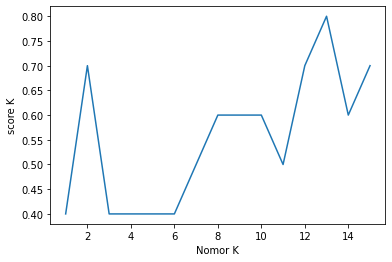

In [19]:
import matplotlib.pyplot as plt
plt.plot(k_range, k_score)
plt.xlabel('Nomor K')
plt.ylabel('score K')
plt.show()

In [91]:
#KNN
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsClassifier(n_neighbors = 13)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [92]:
y_pred = knn.predict(X_test)
y_pred

array(['laridae', 'laridae', 'rallidae', 'rallidae', 'laridae',
       'ardeidae', 'cuculidae', 'cuculidae', 'cuculidae', 'laridae'],
      dtype=object)

In [93]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print("akurasi:",knn.score(X_test, y_test))

              precision    recall  f1-score   support

    ardeidae       1.00      0.33      0.50         3
   cuculidae       1.00      1.00      1.00         3
     laridae       0.50      1.00      0.67         2
    rallidae       1.00      1.00      1.00         2

    accuracy                           0.80        10
   macro avg       0.88      0.83      0.79        10
weighted avg       0.90      0.80      0.78        10

akurasi: 0.8


In [23]:
print(confusion_matrix(y_test, y_pred))

[[1 0 2 0]
 [0 3 0 0]
 [0 0 2 0]
 [0 0 0 2]]


<AxesSubplot:>

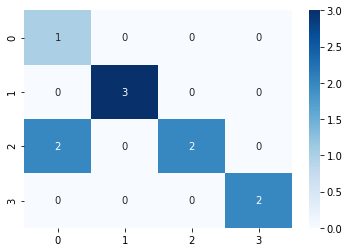

In [24]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_pred, y_test), annot = True, cmap='Blues')

NEW AUDIO INPUT

import warnings
warnings.filterwarnings('ignore')

from tkinter import filedialog
file = filedialog.askopenfilename()
print('Reading file "%s"' % file) #menginput audio baru 
sample_rate, signal = scipy.io.wavfile.read(file)
signal = signal[0:int(1*sample_rate),0] #preprocessing untuk mengubah sinyal analog ke diginal 
pre=pre_emphasis(signal) #pre-emphasis
frames=framming(pre, sample_rate) #frame blocking
window=windowing(frames[0],frames[1]) #windowing
ff=fft(window) #FFT
filter=filter_bank(ff[0],sample_rate, ff[1]) #filterbank
mfcc=cepstral_liftering(filter) #DCT dan cepstral liftering
mfcc=numpy.ndarray.flatten(mfcc)
mfcc=mfcc.reshape(1, -1)

mfcc = scaler.transform(mfcc) #normalisasi data
mfcc #hasil ekstrasi

knn = KNeighborsClassifier(n_neighbors = 13) #knn (k=13)
knn.fit(X_train, y_train)
famili_prediction = knn.predict(mfcc)
print("Prediksi: ", famili_prediction[0])